# <center> Noise modeling</center>

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from tqdm.auto import tqdm

from cam import *
from pgo import *
from plot import *
from linalg import *
from dataset import Dataset

# Edit marker size (in meters) check render script to be sure
MARKER_SIZE = 0.265 #Size of the square (with border): 0.2875*48/50
MARKER_IDS = ['0']
RENDER_PATH = './noise_modeling_render'

In [89]:
def testbench(brightness, contrast):
    B = len(brightness)
    C = len(contrast)

    r_mean = np.zeros((C,B))
    t_mean = np.zeros((C,B))
    r_max  = np.zeros((C,B))
    t_max  = np.zeros((C,B))
    for i, b in tqdm(enumerate(brightness)):
        for j, c in enumerate(contrast):
            cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                                im_filenames=dataset.im_data['filename'],
                                                aruco='DICT_4X4_1000',
                                                marker_size=MARKER_SIZE,
                                                corner_refine='CORNER_REFINE_APRILTAG',
                                                marker_ids=MARKER_IDS,
                                                flags='SOLVEPNP_IPPE_SQUARE',
                                                brightness=b,
                                                contrast=c)
            timesteps = [k[1].split('_')[0] for k, v in cam_marker_edges.items() if v['reprojected_err'] < 0.1]

            gt_camera_marker_poses = {}
            cam_pose = dataset.cams['7'].extrinsics
            for t, v in aruco_pose_dict.items():
                gt_aruco_pose = SE3(R=np.array(v['R']), t=np.array(v['t']))
                gt_camera_marker_poses[t] = cam_pose.inv() @ gt_aruco_pose

            d = []
            r_err = []
            t_err = []
            for t in timesteps:
                est_pose = cam_marker_edges['7', t + '_0']['pose']
                gt_pose  = gt_camera_marker_poses[t]
                r_err.append(distance_SO3(est_pose.R(), gt_pose.R()))
                t_err.append(np.linalg.norm(est_pose.t() - gt_pose.t(), ord=2))
                d.append(np.linalg.norm(gt_pose.t(), ord=2))
            
            r_mean[i,j] += np.mean(r_err)
            r_max[i,j] += np.max(r_err)
            t_mean[i,j] += np.mean(t_err)
            t_max[i,j] += np.max(t_err)
    return r_mean, r_max, t_mean, t_max        

In [90]:
r_mean, r_max, t_mean, t_max = testbench(np.arange(-120,130,10), np.arange(-120,130,10))

0it [00:00, ?it/s]


Marker detection
Received 1353 images.
Started pool of 96 workers.


Merging dictionaries...
Found markers in 15 images
Finished: 8 markers detected.

Marker detection
Received 1353 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 791 images
Finished: 383 markers detected.

Marker detection
Received 1353 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 780 images
Finished: 385 markers detected.

Marker detection
Received 1353 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 751 images
Finished: 365 markers detected.

Marker detection
Received 1353 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 724 images
Finished: 350 markers detected.

Marker detection
Received 1353 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 710 images
Finished: 348 markers detected.

Marker detection
Received 1353 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 689 images
Finished: 337 markers detected.

Marker

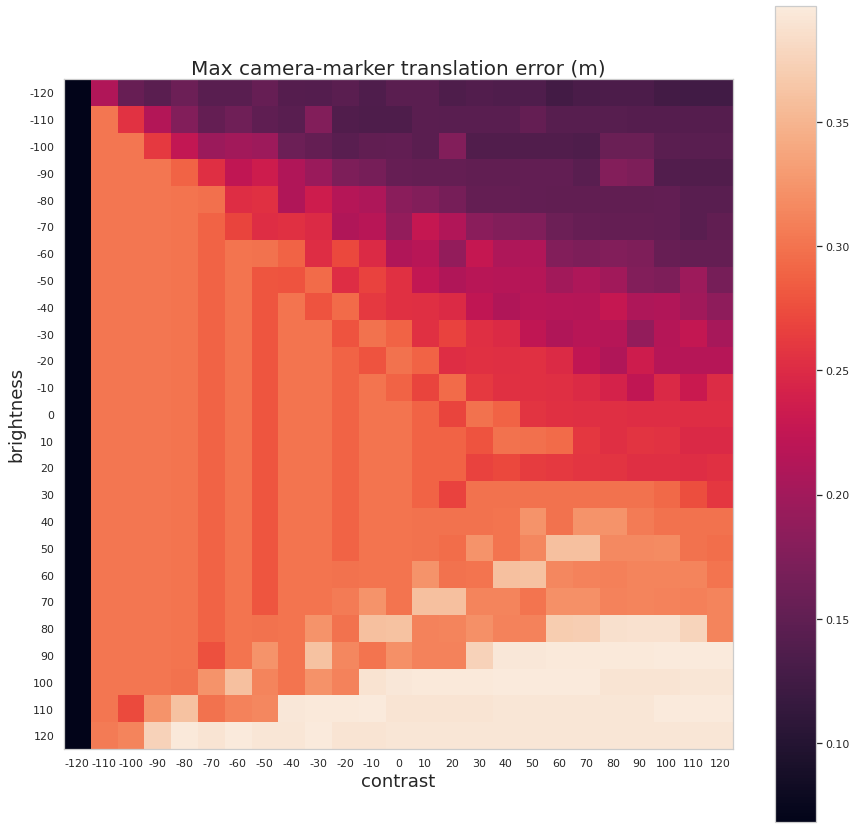

In [123]:
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(15,15))
plt.imshow(t_max, interpolation='none')
plt.colorbar()
plt.title('Max camera-marker translation error (m)', fontsize=20)
plt.xlabel('contrast', fontsize=18)
plt.ylabel('brightness', fontsize=18)
plt.xticks(np.arange(25), np.arange(-120,130,10));
plt.yticks(np.arange(25), np.arange(-120,130,10));

# Detect markers, estimate camera-marker pose through P4P

In [124]:
dataset = Dataset(root=RENDER_PATH)

with open(os.path.join(RENDER_PATH, 'aruco_pose.json')) as f:
    aruco_pose_dict = json.load(f)
    
cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                    im_filenames=dataset.im_data['filename'],
                                    aruco='DICT_4X4_1000',
                                    marker_size=MARKER_SIZE,
                                    corner_refine='CORNER_REFINE_APRILTAG',
                                    marker_ids=MARKER_IDS,
                                    flags='SOLVEPNP_IPPE_SQUARE',
                                    brightness=-120,
                                    contrast=120)

torch.save(cam_marker_edges, os.path.join(RENDER_PATH, './cam_marker_edges.pt'))
timesteps = [k[1].split('_')[0] for k, v in cam_marker_edges.items() if v['reprojected_err'] < 0.1]

gt_camera_marker_poses = {}
cam_pose = dataset.cams['7'].extrinsics
for t, v in aruco_pose_dict.items():
    gt_aruco_pose = SE3(R=np.array(v['R']), t=np.array(v['t']))
    gt_camera_marker_poses[t] = cam_pose.inv() @ gt_aruco_pose

d = []
r_err = []
t_err = []
repro_err = []
alpha = []
x_err, y_err, z_err = [], [], []
for t in timesteps:
    est_pose = cam_marker_edges['7', t + '_0']['pose']
    gt_pose  = gt_camera_marker_poses[t]
    repro_err.append(cam_marker_edges['7', t + '_0']['reprojected_err'])
    r_err.append(distance_SO3(est_pose.R(), gt_pose.R()))
    t_err.append(np.linalg.norm(est_pose.t() - gt_pose.t(), ord=2))
    x_err.append((est_pose.t() - gt_pose.t())[0])
    y_err.append((est_pose.t() - gt_pose.t())[1])
    z_err.append((est_pose.t() - gt_pose.t())[2])
    d.append(np.linalg.norm(gt_pose.t(), ord=2))


Marker detection
Received 1353 images.
Started pool of 96 workers.


Merging dictionaries...
Found markers in 607 images
Finished: 297 markers detected.


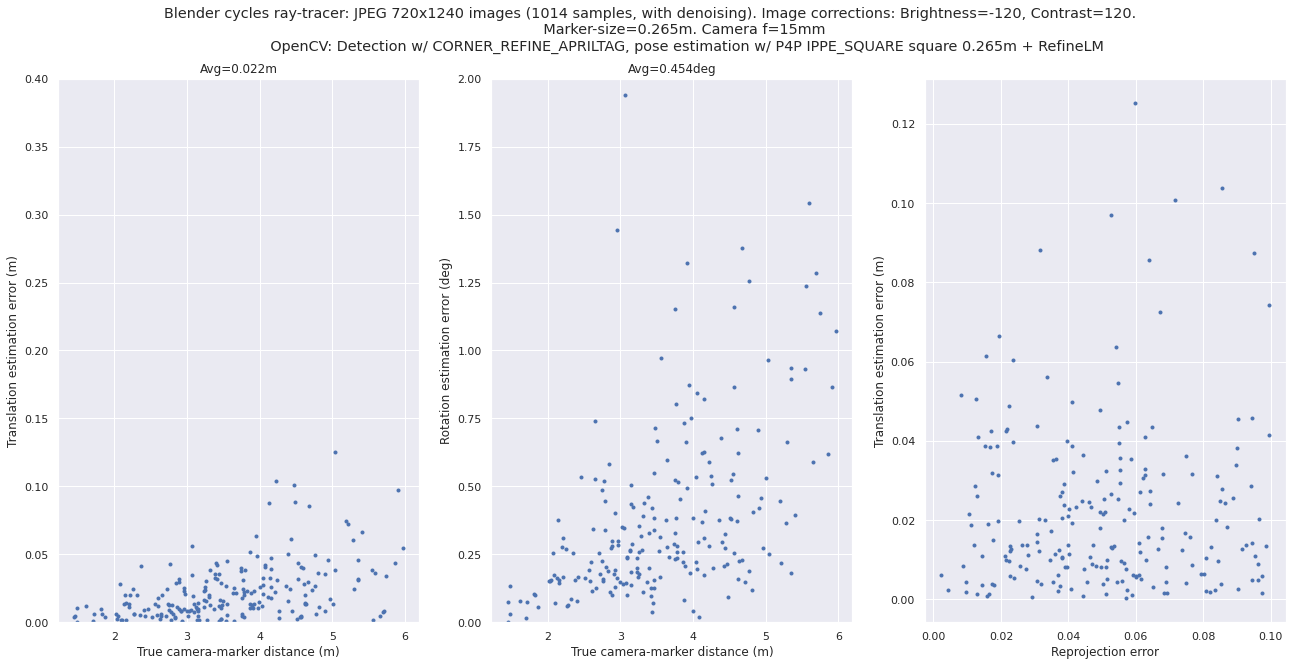

In [125]:
sns.set_theme()
fig = plt.figure(figsize=(22,10))
plt.subplot(1,3,1)
plt.plot(d, t_err, '.')
plt.title('Avg={}m'.format(round(np.mean(t_err),3)))
plt.ylim(0,0.4)
plt.xlabel('True camera-marker distance (m)')
plt.ylabel('Translation estimation error (m)')
plt.subplot(1,3,2)
plt.plot(d, r_err, '.')
plt.title('Avg={}deg'.format(round(np.mean(r_err),3)))
plt.ylim(0,2)
plt.ylabel('Rotation estimation error (deg)')
plt.xlabel('True camera-marker distance (m)')
plt.subplot(1,3,3)
plt.plot(repro_err, t_err, '.')
plt.ylabel('Translation estimation error (m)')
plt.xlabel('Reprojection error')
plt.suptitle("Blender cycles ray-tracer: JPEG 720x1240 images (1014 samples, with denoising). Image corrections: Brightness=-120, Contrast=120. \n \
              Marker-size=0.265m. Camera f=15mm \n \
              OpenCV: Detection w/ CORNER_REFINE_APRILTAG, pose estimation w/ P4P IPPE_SQUARE square 0.265m + RefineLM");
fig.savefig('./plots' + str(int(time.time()))+'.jpg')

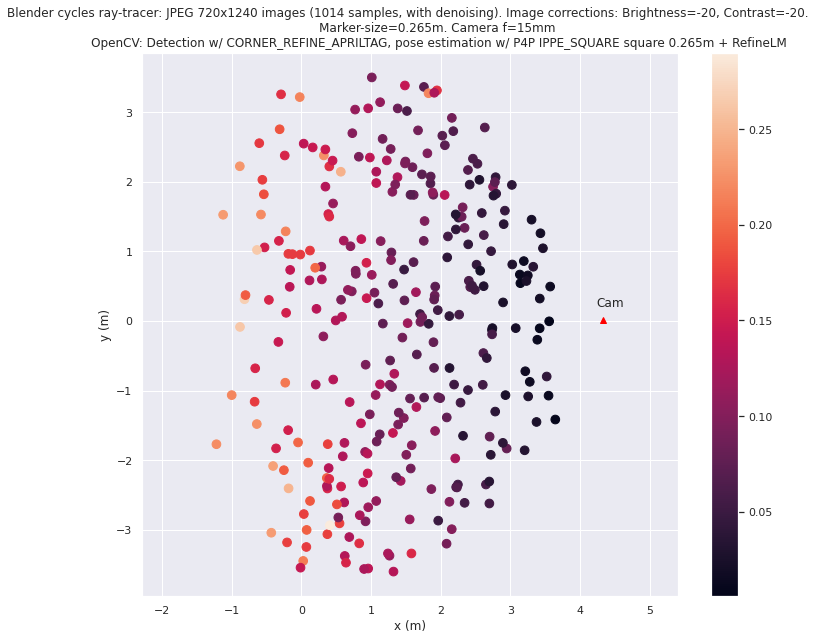

In [47]:
xy = []
c  = []
for i, t in enumerate(timesteps):
    v = aruco_pose_dict[t]
    est = SE3(R=np.array(v['R']), t=np.array(v['t'])).t()
    xy.append(est[:2])
    c.append(t_err[i])
xy = np.stack(xy, axis=0)
fig = plt.figure(figsize=(12,10))
plt.scatter(xy[:,0], xy[:,1], 75, marker='o', c=c)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()
plt.plot(cam_pose.t()[0], cam_pose.t()[1], '^', c='red')
plt.text(cam_pose.t()[0]-0.1, cam_pose.t()[1]+0.2, "Cam")
plt.title("Blender cycles ray-tracer: JPEG 720x1240 images (1014 samples, with denoising). Image corrections: Brightness=-20, Contrast=-20. \n \
              Marker-size=0.265m. Camera f=15mm \n \
              OpenCV: Detection w/ CORNER_REFINE_APRILTAG, pose estimation w/ P4P IPPE_SQUARE square 0.265m + RefineLM");plt.axis('equal')
fig.savefig('./xy' + str(int(time.time()))+'.jpg')